In [2]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import nibabel as nib
from scipy.ndimage import map_coordinates

In [3]:
image_path = "/home/adis/Desktop/Faks/AMS/AMS_Challenge/Data/Abdomen/imagesTr/img0016_tcia_CT.nii.gz"
disp_field_path = "/home/adis/Desktop/Faks/AMS/AMS_Challenge/Results/Optimization_test_aligment/OptimizedAligment/results_testset/disp_16_16.nii.gz"
mr_image_path = "/home/adis/Desktop/Faks/AMS/AMS_Challenge/Data/Abdomen/imagesTr/img0016_tcia_MR.nii.gz"

# Load the images
image = sitk.ReadImage(image_path)
mr_image = sitk.ReadImage(mr_image_path)
print(image.GetSize())

# Load the displacement field as a scalar image
displacement_field_img = sitk.ReadImage(disp_field_path)

(192, 160, 192)


In [4]:
image_array = sitk.GetArrayFromImage(image)
displacement_field_array = sitk.GetArrayFromImage(displacement_field_img)
print(displacement_field_array.shape)
print(image_array.shape)

mr_image_array = sitk.GetArrayFromImage(mr_image)

D, H, W = image_array.shape

(3, 192, 160, 192)
(192, 160, 192)


In [5]:
z, y, x = np.meshgrid(np.arange(D), np.arange(H), np.arange(W), indexing='ij', sparse=False)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
print(x_flat.shape)

disp_x = displacement_field_array[0].flatten()
disp_y = displacement_field_array[1].flatten()
disp_z = displacement_field_array[2].flatten()
print(disp_x.shape)

x_source = x_flat - disp_x
y_source = y_flat - disp_y
z_source = z_flat - disp_z

source_coords = np.vstack((z_source, y_source, x_source))

(5898240,)
(5898240,)


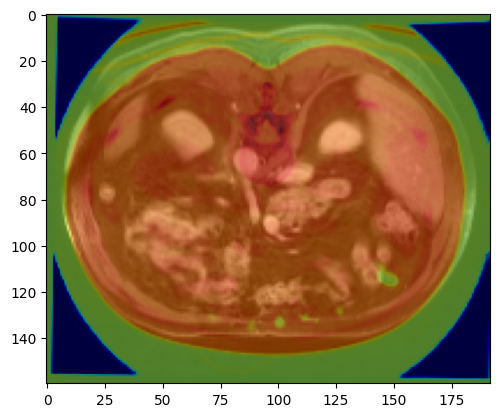

In [13]:
warped_image = map_coordinates(image_array, source_coords, order=1, mode='nearest').reshape((D, H, W))

plt.imshow(mr_image_array[100], cmap='gray')
plt.imshow(warped_image[100], cmap='jet', alpha=0.5)
plt.show()

In [7]:
displacement_field_array = np.transpose(displacement_field_array, (3, 2, 1, 0))
    
displacement_field_vector = sitk.GetImageFromArray(displacement_field_array, isVector=True)
    
displacement_field_vector.CopyInformation(image)
    
displacement_field_vector = sitk.Cast(displacement_field_vector, sitk.sitkVectorFloat64)
    
displacement_transform = sitk.DisplacementFieldTransform(displacement_field_vector)
    
# Resample (warp) the CT image to align with the MR image
warped_ct_image = sitk.Resample(
    image,
    mr_image,  # Use the MR image as a reference
    displacement_transform,  # Displacement field transform
    sitk.sitkBSpline,  # Interpolation method
    0.0,  # Default pixel value for areas outside the image
    image.GetPixelID()  # Ensure output image type matches the MR image
)

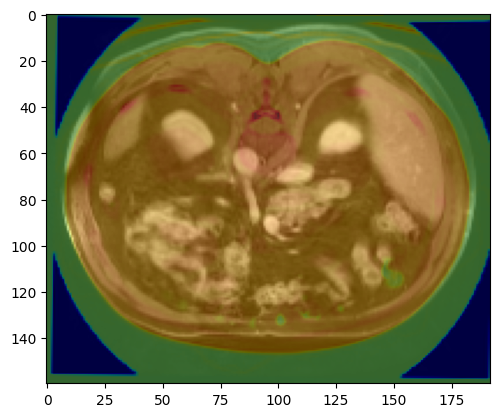

In [15]:
warped_ct_array = sitk.GetArrayFromImage(warped_ct_image)

plt.imshow(mr_image_array[100], cmap='gray')
plt.imshow(warped_ct_array[100], cmap='jet', alpha=0.4)